In [1]:
from collections import Counter

import jax
import jax.numpy as jnp    

import matplotlib.pyplot as plt
from ipywidgets import interact


try:
    import distrax
except ModuleNotFoundError:
    %pip install distrax
    import distrax
try:
    import optax
except ModuleNotFoundError:
    %pip install optax
    import optax

In [2]:
key = jax.random.PRNGKey(1)

# Categorical Distribution

As we know, Bernoulli distribution allowed us to model discrete random variable with only two states, 
what if we wanted to model more than two or may be even hundreds. This is where Categorical Distribution comes into play, it’s a generalization of the Bernoulli distribution for a categorical random variable.

 There are some general criteria for a distribution to be a categorical distribution:
   - The categories are discrete.
   - There are two or more potential categories.
   - The sum of the probabilities for all categories must sum to 1.


Lets take a finite set of label, $ x\ \in\ \{1,...,C\} $

PMF:
\begin{equation}
    p(X = x| \vec{\theta}) = \prod_{c=1}^{C} \theta_c ^{I(x=c)}\ ,\ where\ I(x=c) = \begin{cases}
                                                                              1, & \text{if}\ x==c \\
                                                                              0, & \text{otherwise}
                                                                            \end{cases} \tag{eq. 1}
\end{equation}
In other words,  $p(X = c|\vec{\theta}) = θ_c$.

Lets take the famous example of rolling a fair dice:

So, there are K = 6 categorical outcomes and the probability for each outcome is 1/6 or same because of fair dice.

Sample space would be : { 0, 1, 2, 3, 4, 5}

In [3]:
# fair dice have same probabilities for all categories
theta = [1/6]*6

cat = distrax.Categorical(probs=theta)
n = 1000 # no_of_samples
cat_samples = cat.sample(seed = key, sample_shape=n)

In [4]:
category = jnp.unique(cat_samples)
print("There are {} different category in samples: ".format(len(category)))
print(category)

There are 6 different category in samples: 
[0 1 2 3 4 5]


Text(0, 0.5, 'No. of occurences.')

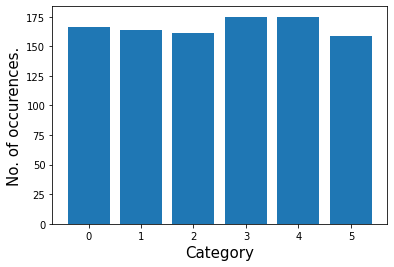

In [5]:
# We can see how many no. of occurence of each category are in samples.
count_cat_samples = Counter(cat_samples.tolist())
_ = plt.bar(count_cat_samples.keys(), count_cat_samples.values())
plt.xlabel("Category", fontsize=15)
plt.ylabel("No. of occurences.", fontsize=15)

In [6]:
# we can find out probs by inbuilt function of distrax
print(cat.prob([1, 0, 6, 7, -1]))

[0.16666667 0.16666667 0.         0.         0.        ]


### PMF AND CDF PLOTS

Let takes 4 different outcomes that have different probabilites i.e.
<center> $ Categories = \{ a, b, c, d \} $ </center>

And we know that sum of the probabilities for all categories must sum to 1.<br>
Therefore,
<br><center>**We can see below that we are interactively changing the categorys except d. Because its deciding by the sum of other categories.**</center>
<br><center>$ 1 = p(a) + p(b) + p(c) + p(d)$</center>
<br><center>$ p(d) = 1 - (p(a) + p(b) + p(c)) $</center>

In [7]:
def draw_plots(p_a=0.1, p_b=0.1, p_c=0.1):
    p_d = 1 - jnp.sum(jnp.array([p_a, p_b, p_c]))
    theta = [p_a, p_b, p_c, p_d]
    
    cat = distrax.Categorical(probs=jnp.array(theta))
    n = 100 # no_of_samples
    cat_samples = cat.sample(seed = key, sample_shape=n)
    
    category = jnp.unique(cat_samples)
    pdf = cat.prob(cat_samples)
    cdf = cat.cdf(cat_samples)

    fig, ax = plt.subplots(1,2,figsize=(12,5))

    ax[0].stem(cat_samples, pdf)
    ax[0].set_xlabel("x", fontsize=15)
    ax[0].set_ylabel("P(x)", fontsize=15)
    ax[0].set_ylim(0,1)
    ax[0].spines['top'].set_color('none')
    ax[0].spines['right'].set_color('none')
    
    
    
    
    ax[1].bar(cat_samples,cdf)
    
    ax[1].set_xlabel("x", fontsize=15)
    ax[1].set_ylabel("CDF(x)", fontsize=15)  
    ax[1].spines['top'].set_color('none')
    ax[1].spines['right'].set_color('none')
    
    plt.show()

interact(draw_plots,p_a=(0.01,1,0.05),p_b=(0.01,1,0.05),p_c=(0.01,1,0.05))

interactive(children=(FloatSlider(value=0.1, description='p_a', max=1.0, min=0.01, step=0.05), FloatSlider(val…

<function __main__.draw_plots(p_a=0.1, p_b=0.1, p_c=0.1)>

# Maximum Likelihood Estimation of Categorical distribution

The likelihood that the sample X follows the distribution defined by the set of parameters $\theta $ 
equals the product of the likelihoods of the individual instances $x_t$.<br>
Let us say we have observed some data $D = [x_1,x_2...x_n ]$,

\begin{equation}
L(\vec{\theta}|D) ≡ p(D|\vec{\theta}) = \prod_{t=1}^{N} p(x_t|\vec{\theta}) \tag{eq. 2}
\end{equation}

Our goal is to find the set of parameters θ that maximizes the likelihood estimation $L(θ|D)$.
This is given by :
\begin{equation}
\vec{\theta}^∗ =  argmax_\theta (L(\vec{\theta}| D))
\end{equation}
 So,
\begin{align} 
L(\vec{\theta}|D) &=  \prod_{t=1}^{N} \prod_{c=1}^{C} \theta_c ^{I(x_t\ =\ c)} \tag{from eq. 1 and eq. 2} \\ \\
    l &= \log{L(\vec{\theta}|D)} \tag{eq. 3} \\ \\
\end{align}
Maximizing the likelihood function derived above can be a complex operation, so we can simplify it by taking the natural logarithm of the equation 2.


<br>
\begin{equation}
l = \sum_{t=1}^{N} \sum_{c=1}^{C} I(x_t = c) \log{(\theta_c)} \tag{eq. 4}
\end{equation}
The logarithm of a function is also a monotonically increasing function. So maximizing the logarithm of the likelihood function, would also be equivalent to maximizing the likelihood function.<br>


## Programmatically Solve MLE of Categorical Distribution

So, we will use a gradient descent algorithm for minimization of the negative likelihood function, which would also be equivalent to maximizing the likelihood function.


Before we use gradient descent algorithm, we need following primary parameters,
1. Loss Function : ( we use negative of equation 4.)
2. Initial values of $\vec{\theta}$
3. Learning rate : which scales the gradient and controls the step size of parameters.

In [15]:
# Negative of likelihood function of categorical distribution (eq. 4.)
def loss_function(thetas, samples):
    thetas = jax.nn.softmax(thetas)
    result_fit = distrax.Categorical(probs= thetas)
    return -jnp.sum(result_fit.log_prob(samples))/len(samples)

In [16]:
class Model():
    def __init__(self, samples, thetas):
        self.samples = samples
        self.thetas = thetas 
        self.grads = [0]*len(thetas)
        
    def probs(self):
        return jax.nn.softmax(self.thetas)

    def fit(self, optimizer, epochs):
        opt_state = optimizer.init(self.thetas)
        for i in range(epochs):    
            loss, self.grads = jax.value_and_grad(loss_function)(self.thetas, self.samples)
            
            updates, opt_state = optimizer.update(self.grads, opt_state, self.thetas)
            self.thetas = optax.apply_updates(self.thetas, updates)
            
            if i%10 == 0:
                print(f"Loss at epoch {i} : ",loss)
        
    

In [17]:
# initialize default parametrs
learning_rate = 1e-4
init_thetas = jnp.array([0.5,0.5])

In [18]:
# Lets generate some samples 
cat = distrax.Categorical(probs = [0.2, 0.8])
samples = cat.sample(seed = jax.random.PRNGKey(1), sample_shape = 1000)

In [19]:
optimizer = optax.adam(learning_rate = 0.1)

model = Model(samples, init_thetas)
model.fit(optimizer=optimizer, epochs = 100)

Loss at epoch 0 :  0.69314724
Loss at epoch 10 :  0.4723168
Loss at epoch 20 :  0.48604885
Loss at epoch 30 :  0.46990055
Loss at epoch 40 :  0.47188267
Loss at epoch 50 :  0.4701206
Loss at epoch 60 :  0.46998137
Loss at epoch 70 :  0.4699761
Loss at epoch 80 :  0.4698781
Loss at epoch 90 :  0.4698786


In [20]:
print("Initial : ", init_thetas)
print("Learned : ", model.probs())


Initial :  [0.5 0.5]
Learned :  [0.18020472 0.8197953 ]


# Theoretical Derivation of MLE for Categorical distribution
Before we can differentiate the log-likelihood to find the maximum,<br>
we need to introduce the constraint that all probabilities $\theta $ sum up to 1, that is :
\begin{equation}
\sum_{c=1}^{C} \theta_c = 1 \tag{eq. 5}
\end{equation}

Then we use the lagrangian function with the constraint than has the following form :
\begin{equation}
l(\theta, \lambda) = \log{(L(\theta))} + \lambda(1 - \sum_{c=1}^{C} \theta_c) \tag{eq. 6}
\end{equation}


To find the maximum, we differentiate the lagrangian w.r.t. $\theta$ as follows:
\begin{align}
\frac{\partial l}{\partial \theta_c} &= \frac{\sum_{t=1}^{N}I(x_t = c)}{\theta_c}  - \lambda = 0  \tag{from eq. 4},   \\
                             \lambda &= \frac{\sum_{t=1}^{N}I(x_t = c)}{\theta_c}, \\
\therefore                  \theta_c &= \frac{N_c}{\lambda} \tag{$N_c$ = no. of occurences that belongs to $\it{c}$ category}\\
                                     &\tag{eq. 7}
\end{align}

To solve for $\lambda$, we sum both side and make use of our initial constraint:
\begin{align}
               \theta_c &= \frac{N_c}{\lambda}, \\
   \sum_{c=1}^{C}\theta &= \frac{1}{\lambda} \sum_{c=1}^{C}N_c, \\
                    1   &= \frac{1}{\lambda} n \tag{n = sum of all $N_c$} \\
     \therefore \lambda &= n
\end{align}

Let put $\lambda$ in eq 7. that giving us the MLE for $\theta$:
\begin{align}
        \theta_c &= \frac{N_c}{n}
\end{align}

In [21]:
# Lets find out MlE for above distribution
key = jax.random.PRNGKey(1)

n2 = 1000
true_thetas = [0.3,0.3,0.4]

cat2 = distrax.Categorical(probs=true_thetas)
cat_samples2 = cat2.sample(seed = key, sample_shape=n2)
category = jnp.unique(cat_samples2)

mle_thetas = [round(float(jnp.sum(cat_samples2 == i)/n2),3) for i in category]


print("Theta's values \t\t:",true_thetas)
print("Theta's values by MLE\t:",mle_thetas)

Theta's values 		: [0.3, 0.3, 0.4]
Theta's values by MLE	: [0.327, 0.28, 0.393]
